<a href="https://colab.research.google.com/github/nitsansoffair/bounding_boxes/blob/master/bounding_boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting bounding boxes

In [35]:
from google.colab import drive, files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


#### imports.

In [3]:
import os, re, time, json
import math
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

#### store the path to the data.

In [4]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

#### visualization utilities.


In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2], color[i], thickness)

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    draw_bounding_boxes_on_image(image, boxes, color, thickness)
    return image

#### data and predictions utilities.

In [6]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0') 
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):
    n = len(images)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)
      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
      plt.imshow(img_to_draw)
      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
def plot_metrics(history, metric_name, title, ylim=5):
    plt.title(title), plt.ylim(0,ylim), plt.plot(history.history[metric_name],color='blue',label=metric_name), plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

#### read image tfds procedure.

In [7]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)
    image = tf.image.resize(image, (224, 224,))
    image = image/127.5
    image -= 1
    bbox_list = [bbox[0] / factor_x , bbox[1] / factor_y, bbox[2] / factor_x , bbox[3] / factor_y]
    return image, bbox_list

#### read image with shape procedure.

In [8]:
def read_image_with_shape(image, bbox):
    original_image = image
    image, bbox_list = read_image_tfds(image, bbox)
    return original_image, image, bbox_list

#### read image tfds with original bounding box procedure.

In [9]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]
    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)
    bbox_list = [bbox[1] * factor_x ,  bbox[0] * factor_y, bbox[3] * factor_x, bbox[2] * factor_y]
    return image, bbox_list

#### dataset to numpy util procedure.

In [10]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
    take_dataset = dataset.shuffle(1024)
    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
    if N > 0:
        take_dataset = take_dataset.take(N)
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
    return (np.array(ds_images), np.array(ds_bboxes))

#### dataset to numpy with original bounded boxes util procedure.

In [11]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):
    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)
    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())
    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

#### Visualize the images and their bounding box labels.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


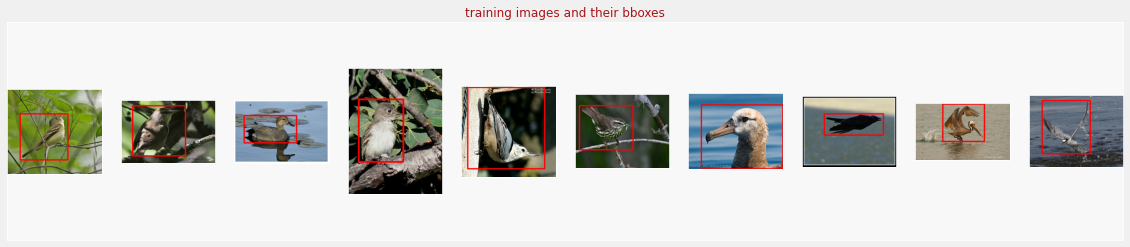

In [12]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_training_dataset, info

visualization_training_dataset, info = get_visualization_training_dataset()
visualization_training_images, visualization_training_bboxes = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

#### Visualize the **validation** images and their bounding boxes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


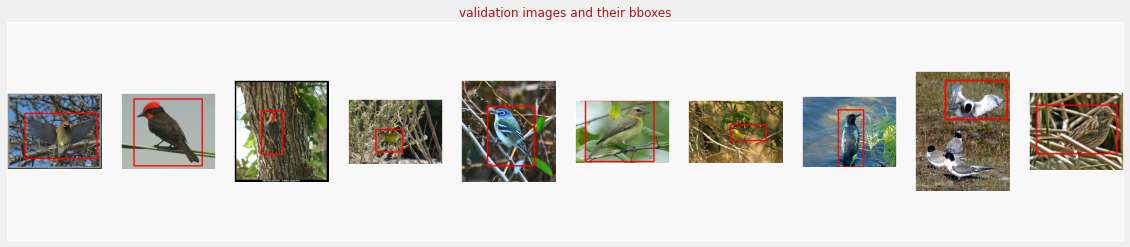

In [13]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()
(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

#### Load and prepare the datasets for the model.

In [14]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

#### define the network.

In [15]:
def feature_extractor(inputs):
    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    feature_extractor = mobilenet_model(inputs)
    return feature_extractor

In [16]:
def dense_layers(features):
    x = tf.keras.layers.GlobalAveragePooling2D()(features)  
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)  
    return x

In [17]:
def bounding_box_regression(x):
    bounding_box_regression_output = tf.keras.layers.Dense(4, activation='relu', name="bounding_box")(x)
    return bounding_box_regression_output

In [18]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    last_dense_layer = dense_layers(feature_cnn) 
    bounding_box_output = bounding_box_regression(last_dense_layer)
    model = tf.keras.Model(inputs=inputs, outputs=bounding_box_output)    
    return model

In [19]:
def define_and_compile_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    model = final_model(inputs)
    model.compile(loss=tf.keras.losses.Huber(), metrics=['accuracy'])
    return model

#### define model and print the model summary.

In [20]:
model = define_and_compile_model()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                

#### configure data and parameters.

In [21]:
length_of_training_dataset, length_of_validation_dataset = len(visualization_training_dataset), len(visualization_validation_dataset)
steps_per_epoch, validation_steps = math.ceil(length_of_training_dataset / BATCH_SIZE) + 1, math.ceil(length_of_validation_dataset / BATCH_SIZE) + 1

#### configure epochs number.

In [22]:
EPOCHS = 50

#### configure checkpoints.

In [23]:
checkpoint_filepath = '/content/drive/My Drive/coursera/bounding_boxes/model.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

#### Load model weights.

In [24]:
model.load_weights(checkpoint_filepath)

#### Fit model to data.

In [29]:
history = model.fit(x=training_dataset, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS, 
                    callbacks=[model_checkpoint_callback])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 6.7150e-04 - accuracy: 0.9183INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


48/48 [==============================] - 89s 2s/step - loss: 6.7150e-04 - accuracy: 0.9183 - val_loss: 0.0137 - val_accuracy: 0.5557
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 6.1693e-04 - accuracy: 0.9242INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


48/48 [==============================] - 74s 2s/step - loss: 6.1693e-04 - accuracy: 0.9242 - val_loss: 0.0191 - val_accuracy: 0.6287
Epoch 3/50
48/48 [==============================] - 49s 1s/step - loss: 6.0860e-04 - accuracy: 0.9134 - val_loss: 0.0124 - val_accuracy: 0.4708
Epoch 4/50
48/48 [==============================] - 49s 1s/step - loss: 5.9659e-04 - accuracy: 0.9235 - val_loss: 0.0087 - val_accuracy: 0.5534
Epoch 5/50
48/48 [==============================] - 49s 1s/step - loss: 5.9200e-04 - accuracy: 0.9085 - val_loss: 0.0112 - val_accuracy: 0.5831
Epoch 6/50
48/48 [==============================] - 49s 1s/step - loss: 5.9149e-04 - accuracy: 0.9141 - val_loss: 0.0082 - val_accuracy: 0.6258
Epoch 7/50
48/48 [==============================] - ETA: 0s - loss: 5.7477e-04 - accuracy: 0.9238INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


48/48 [==============================] - 75s 2s/step - loss: 5.7477e-04 - accuracy: 0.9238 - val_loss: 0.0074 - val_accuracy: 0.6568
Epoch 8/50
48/48 [==============================] - ETA: 0s - loss: 5.4489e-04 - accuracy: 0.9261INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


48/48 [==============================] - 73s 2s/step - loss: 5.4489e-04 - accuracy: 0.9261 - val_loss: 0.0104 - val_accuracy: 0.6635
Epoch 9/50
48/48 [==============================] - ETA: 0s - loss: 5.2272e-04 - accuracy: 0.9199INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


48/48 [==============================] - 75s 2s/step - loss: 5.2272e-04 - accuracy: 0.9199 - val_loss: 0.0093 - val_accuracy: 0.7740
Epoch 10/50
48/48 [==============================] - 49s 1s/step - loss: 5.0673e-04 - accuracy: 0.9281 - val_loss: 0.0109 - val_accuracy: 0.7449
Epoch 11/50
48/48 [==============================] - 48s 1s/step - loss: 5.2585e-04 - accuracy: 0.9284 - val_loss: 0.0117 - val_accuracy: 0.6109
Epoch 12/50
48/48 [==============================] - 48s 1s/step - loss: 4.8288e-04 - accuracy: 0.9274 - val_loss: 0.0130 - val_accuracy: 0.6839
Epoch 13/50
48/48 [==============================] - 49s 1s/step - loss: 4.9506e-04 - accuracy: 0.9232 - val_loss: 0.0122 - val_accuracy: 0.6807
Epoch 14/50
48/48 [==============================] - 48s 1s/step - loss: 4.9433e-04 - accuracy: 0.9229 - val_loss: 0.0132 - val_accuracy: 0.6167
Epoch 15/50
48/48 [==============================] - 49s 1s/step - loss: 4.3615e-04 - accuracy: 0.9346 - val_loss: 0.0119 - val_accuracy: 0.62

INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


48/48 [==============================] - 76s 2s/step - loss: 4.1443e-04 - accuracy: 0.9297 - val_loss: 0.0114 - val_accuracy: 0.7808
Epoch 29/50
48/48 [==============================] - 48s 1s/step - loss: 3.6884e-04 - accuracy: 0.9365 - val_loss: 0.0091 - val_accuracy: 0.7491
Epoch 30/50
48/48 [==============================] - 49s 1s/step - loss: 3.7848e-04 - accuracy: 0.9362 - val_loss: 0.0154 - val_accuracy: 0.7627
Epoch 31/50
48/48 [==============================] - 48s 1s/step - loss: 3.8363e-04 - accuracy: 0.9395 - val_loss: 0.0127 - val_accuracy: 0.7617
Epoch 32/50
48/48 [==============================] - 49s 1s/step - loss: 3.9230e-04 - accuracy: 0.9440 - val_loss: 0.0090 - val_accuracy: 0.7604
Epoch 33/50
48/48 [==============================] - 49s 1s/step - loss: 3.7445e-04 - accuracy: 0.9391 - val_loss: 0.0097 - val_accuracy: 0.7475
Epoch 34/50
48/48 [==============================] - 49s 1s/step - loss: 3.4032e-04 - accuracy: 0.9417 - val_loss: 0.0100 - val_accuracy: 0.76

INFO:tensorflow:Assets written to: /content/drive/My Drive/coursera/bounding_boxes/model.ckpt/assets


48/48 [==============================] - 74s 2s/step - loss: 3.4810e-04 - accuracy: 0.9365 - val_loss: 0.0075 - val_accuracy: 0.7946
Epoch 45/50
48/48 [==============================] - 49s 1s/step - loss: 3.4844e-04 - accuracy: 0.9408 - val_loss: 0.0087 - val_accuracy: 0.7507
Epoch 46/50
48/48 [==============================] - 49s 1s/step - loss: 3.0684e-04 - accuracy: 0.9450 - val_loss: 0.0110 - val_accuracy: 0.7850
Epoch 47/50
48/48 [==============================] - 49s 1s/step - loss: 3.6009e-04 - accuracy: 0.9434 - val_loss: 0.0117 - val_accuracy: 0.7472
Epoch 48/50
48/48 [==============================] - 49s 1s/step - loss: 3.1478e-04 - accuracy: 0.9427 - val_loss: 0.0157 - val_accuracy: 0.7678
Epoch 49/50
48/48 [==============================] - 49s 1s/step - loss: 3.2699e-04 - accuracy: 0.9333 - val_loss: 0.0117 - val_accuracy: 0.7646
Epoch 50/50
48/48 [==============================] - 49s 1s/step - loss: 3.2254e-04 - accuracy: 0.9447 - val_loss: 0.0117 - val_accuracy: 0.72

#### validate model.

In [30]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

49/49 [==============================] - 16s 325ms/step - loss: 0.0117 - accuracy: 0.7236
Loss:  [0.011745178140699863, 0.7236034870147705]


#### plot the loss metrics.

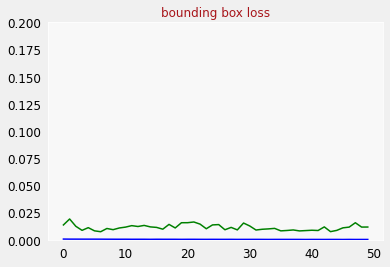

In [31]:
plot_metrics(history, "loss", "bounding box loss", ylim=0.2)

#### evaluate performance with iou.

In [32]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    smoothing_factor = 1e-10
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    return iou

original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=BATCH_SIZE)

iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = .5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


Number of predictions where iou > threshold(0.5): 276
Number of predictions where iou < threshold(0.5): 224


#### visualize predictions.


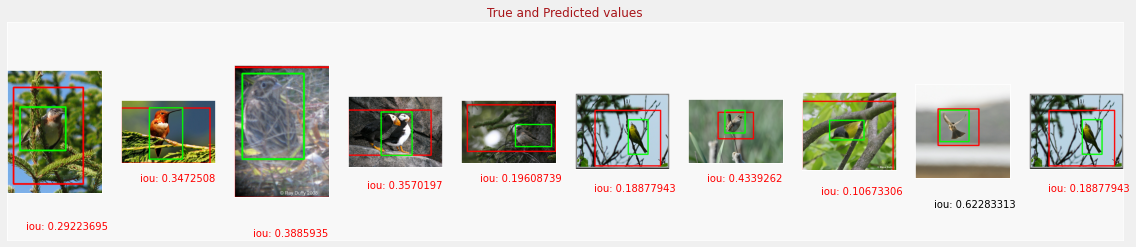

In [33]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)

#### save model.

In [34]:
model.save("birds.h5")

#### downlaod model.

In [36]:
files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## References:
Coursera - Advanced computer vision with tensorflow [course](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow).